In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [3]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [5]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [6]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

The Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. 

As the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a positional embedding layer. 

The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

In this tutorial, they we used a learned positional encoding instead of a static one unlike the original paper, "Attention is all you need".

The token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, hid_dim. This supposedly reduces variance in the embeddings

Also, masking is used in the source sentence to ignore $<pad>$ tokens.

In [9]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        # token embedding
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # positional embedding
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        # make n layer objects and store it as a module list
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        # scaling factor, sqrt(hid_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # pos = [batch size, src len]
        # scale tok_embedding by self.scale, concatenate it with pos_embedding, then pass em to dropout
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        # src = [batch size, src len, hid dim]
        # iterate through pre-defined number of layers
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

Layer normalization is used to normalize features, i.e. elements in a hidden state vector, into N(0,1) to encourage convergence. 

This technique is common in regular supervised learning algorithms, where we're encouraged to normalize features into the same scale.

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        # normalize hidden states or vectors (the second and the last step)
        self.layer_norm = nn.LayerNorm(hid_dim)
        # multi-head self-attention layer (the first step)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        # position-wise feedforward layer (the third step)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        # dropout, residual connection and layer norm
        # this layer_norm takes the sum of the original source matrix and the source matrix passed through self-attention layer
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        # dropout, residual and layer norm
        # this layer_norm takes the sum of the output of the first layer_norm and the output of the first layer_norm passed through positional feedforward layer
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

Queries and Keys are used to computate attentinal vectors (weight of each token).
Then, the weighted sum will be computed by multiplying each token in Values by Weights.

, where $\sum_{i=1}^{src\_len} \alpha_{i} = 1$, $\alpha_{i} \in A: A = \text{Softmax}(\frac{QK^{T}}{\sqrt{d_{k}}})$ and $ \alpha_{i} = [0,1]$ 


In self-attention scheme, Queries = Keys = Values = [src length, src_emb_dim] without batch.

Formally,

$$Z_{i} = \text{head}_i = \text{Attention}(Q_{i}, K_{i}, V_{i}) \\ \text{, where } Q_{i} = XW_i^Q, K_{i} = XW_i^K, W_{i} = XW_i^V \text{: X = src}$$

Then,

$$ Z = \text{MultiHead}(Q, K, V) = [Z_{1};Z_{2}; \dots ;Z_{n\_heads}]W^{O} \\ \text{, where ";" is a matrix concatenation}$$

In [11]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        # the dimension of hidden state in a head
        self.hid_dim = hid_dim
        # the number of heads
        self.n_heads = n_heads
        # the dimension of each head, denoted as d_{k} in the tutorial
        # head_dim = 64 if hid_dim = 256 and n_heads = 4
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        # sqrt(head_dim)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    # For self-attention heads in encoder, query = key = value = src
    # For self-attention heads in decoder, query = key = value = trg
    # For attention heads in the second layer of decoder, query = current hidden state, and key = value = output of decoder (hidden states of all tokens) 
    # Also, decoder masks tokens on the right-hand side of the current token to prevent network from cheating during training 
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        # Q = [batch size, query len, hid dim], Q = XW^{Q}
        # K = [batch size, key len, hid dim], K = XW^{K}
        # V = [batch size, value len, hid dim], V = XW^{V}
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Split Q, K, and V into multiple heads
        # e.g. if hid_dim = 256 and n_heads = 4
        # , Q = [batch size, query len, hid dim] -> [batch size, query len, 4, 64] by view -> [batch size, 4, query len, 64] by permute(0,2,1,3)
        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # non-normalized attentional weights
        # energy = [batch size, n heads, seq len, seq len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # mask is not None for decoder
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        # normalize attention weights by softmax 
        # attention = [batch size, n heads, query len, key len]
        attention = torch.softmax(energy, dim = -1)
                
        # calculate the weighted sum of source tokens
        # x = [batch size, n heads, seq len, head dim]
        x = torch.matmul(self.dropout(attention), V)
        
        # x = [batch size, seq len, n heads, head dim]        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        # x = [batch size, seq len, hid dim]
        x = x.view(batch_size, -1, self.hid_dim)
        
        # Get the context vector by concatenating all heads and multiply it by W^{O}
        # x = [batch size, seq len, hid dim]        
        x = self.fc_o(x)
        
        return x, attention

In [12]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        # Empirically, hid_dim << pf_dim
        # The original Transformer used a hid_dim of 512 and a pf_dim of 2048. 
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # input x = [batch size, seq len, hid dim]

        # map normalized self-attention states into positional feedforward states 
        # x = [batch size, seq len, pf dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        # map positional feedforward states into output 
        # x = [batch size, seq len, hid dim]
        x = self.fc_2(x)

        return x

In the second multi-head attention layer, decoder uses the encoder outputs (a bunch of hidden states for tokens in source sentence) as the key and the value, and the query is its current token

In [2]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        # word embeddings
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        # positional embeddings
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        # Store a bunch of layers as module list
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        # scaling factor, which is sqrt(the dimension of hidden states in decoder)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        # Duplicate positional vector by batch size so each sentence has its own positional vector 
        # pos = [batch size, trg len]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        # word embedding + positional embedding
        # trg = [batch size, trg len, hid dim]
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        # src_mask to ignore <pad> tokens in source sentence
        # trg_mast to ignore right-hand side of the current token
        # passes an embedded sentence with a positional embedding
        # passes hidden states of all tokens
        # Since softmax will be applied in loss function, it just returns the output of Linear function
        # trg = [batch size, trg len, hid dim]
        # attention = [batch size, n heads, trg len, src len]
        # Theoritically, the quality of trg get better as it goes through layers
        for layer in self.layers:
            # trg is the output of a decoder layer
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        # output = [batch size, trg len, output dim]
        # linear layer operation at the end of decoder
        output = self.fc_out(trg)
        
        return output, attention

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        # The first step of a decoder layer
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        # The second step of a decoder layer 
        # hidden states of encoder + hidden states of target sentences after passed through self-attention layer
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        # The last step of a decoder layer
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        # self attention
        # notice that it takes trg_mask to prevent cheating
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        # encoder attention, combining encoder outputs and target tokens after self-attention layer
        # notice that query is trg itself, and key and value are encoder output
        # this takes src_mast so it doesn't pay attention to <pad>s in source sentence 
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

It creates src_mask to tell the position of <pad> tokens in a source sentence, and trg_mask as a diagonal matrix for each sentence that prevents decoder from seeing the right-hand side of the current token.

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        # if index of a token is equal to index of <pad>, the value will be 0
        # it's unsqueezed twice to be applied to multihead later, i.e. [batch size, n heads, src len, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        # Create a mask for <pad> tokens
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        
        #trg_pad_mask = [batch size, 1, trg len, 1]
        
        trg_len = trg.shape[1]
        # tril creates a diagonal matrix for a tensor
        # Thus, the output will be a square matrix, i.e. trg_sub_mask = [trg len, trg len]
        # Using bool() to ensure the datatype of elements in trg_sub_mask
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        # We'll augment this mask for each sentence in a batch, then combine it with pad_mask
        # (e.g. trg_sub_mask = [[1,0,0], [1,1,0], [1,1,1]] with trg_len = 3)
        # (e.g. trg_mask = [[1,0,0], [1,1,0], [1,1,0]] if trg_pad_mask = [1,1,0]
        # Thus, trg_mask = [batch size, 1, trg len, trg len], where 1 is for multi-head
        trg_mask = trg_pad_mask & trg_sub_mask    
    
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        # The output is hidden states of encoder
        # enc_src = [batch size, src len, hid dim]
        enc_src = self.encoder(src, src_mask)

        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        return output, attention

In [16]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [17]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,034,245 trainable parameters


In [19]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [20]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (lay

In [21]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [22]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [23]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        # strip <eos> token in trg
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        # strip <sos> token cuz a predicted sentence doesn't contain <sos>
        # this is important when we calculate the loss
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 31s
	Train Loss: 3.636 | Train PPL:  37.922
	 Val. Loss: 2.625 |  Val. PPL:  13.802
Epoch: 02 | Time: 0m 31s
	Train Loss: 2.477 | Train PPL:  11.907
	 Val. Loss: 2.091 |  Val. PPL:   8.092
Epoch: 03 | Time: 0m 31s
	Train Loss: 2.015 | Train PPL:   7.502
	 Val. Loss: 1.855 |  Val. PPL:   6.389
Epoch: 04 | Time: 0m 29s
	Train Loss: 1.732 | Train PPL:   5.652
	 Val. Loss: 1.717 |  Val. PPL:   5.567
Epoch: 05 | Time: 0m 29s
	Train Loss: 1.531 | Train PPL:   4.622
	 Val. Loss: 1.664 |  Val. PPL:   5.280
Epoch: 06 | Time: 0m 30s
	Train Loss: 1.373 | Train PPL:   3.947
	 Val. Loss: 1.648 |  Val. PPL:   5.194
Epoch: 07 | Time: 0m 31s
	Train Loss: 1.248 | Train PPL:   3.483
	 Val. Loss: 1.643 |  Val. PPL:   5.171
Epoch: 08 | Time: 0m 29s
	Train Loss: 1.142 | Train PPL:   3.132
	 Val. Loss: 1.639 |  Val. PPL:   5.150
Epoch: 09 | Time: 0m 30s
	Train Loss: 1.052 | Train PPL:   2.862
	 Val. Loss: 1.651 |  Val. PPL:   5.211
Epoch: 10 | Time: 0m 29s
	Train Loss: 0.973 | Train PPL

In [27]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.671 | Test PPL:   5.318 |


In [28]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [29]:

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [30]:
example_idx = 100

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['männliches', 'kleinkind', 'in', 'einem', 'roten', 'hut', ',', 'das', 'sich', 'an', 'einem', 'geländer', 'festhält', '.']
trg = ['toddler', 'boy', 'in', 'a', 'red', 'hat', 'holding', 'on', 'to', 'some', 'railings', '.']


In [31]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['toddler', 'in', 'a', 'red', 'hat', 'holding', 'up', 'to', 'a', 'railing', '.', '<eos>']


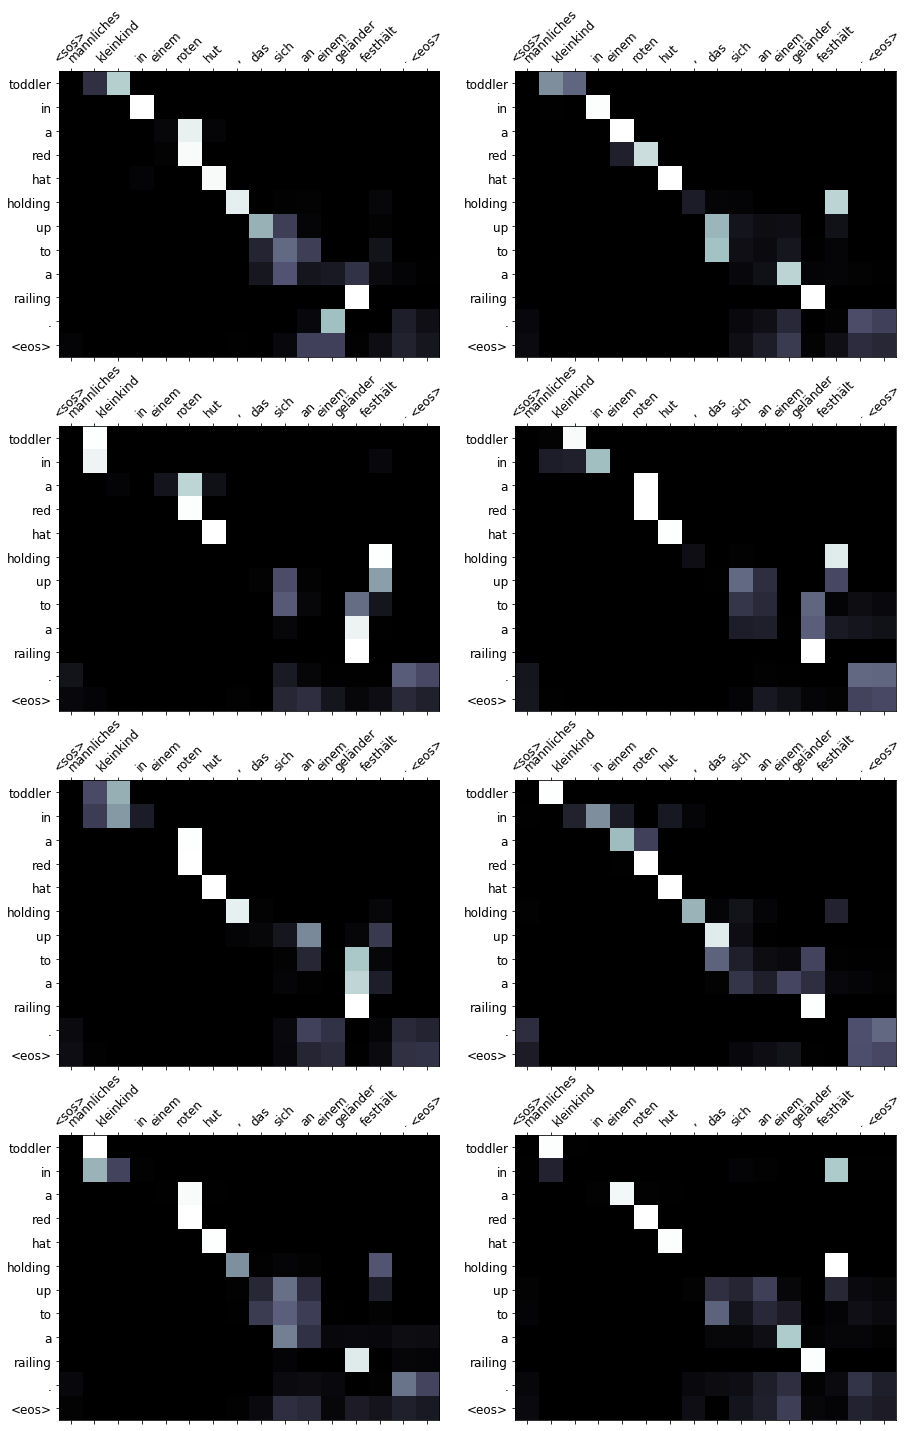

In [32]:
display_attention(src, translation, attention)

In [33]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [34]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.28
